In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [2]:
meta = pd.read_csv("MovieSummaries/movie.metadata.tsv", sep = '\t', 
                   header = None)
meta.head()

meta.head()           0           1  \
0    975900   /m/03vyhn   
1   3196793   /m/08yl5d   
2  28463795  /m/0crgdbh   
3   9363483  /m/0285_cd   
4    261236   /m/01mrr1   

                                                       2           3  \
0                                         Ghosts of Mars  2001-08-24   
1  Getting Away with Murder: The JonBenét Ramsey Mystery  2000-02-16   
2                                            Brun bitter        1988   
3                                       White Of The Eye        1987   
4                                      A Woman in Flames        1983   

            4      5                                   6  \
0  14010832.0   98.0  {"/m/02h40lc": "English Language"}   
1         NaN   95.0  {"/m/02h40lc": "English Language"}   
2         NaN   83.0  {"/m/05f_3": "Norwegian Language"}   
3         NaN  110.0  {"/m/02h40lc": "English Language"}   
4         NaN  106.0   {"/m/04306rv": "German Language"}   

                               

In [3]:
# rename columns
meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]

plots = []

with open("MovieSummaries/plot_summaries.txt", 'r') as f:
    reader = csv.reader(f, dialect='excel-tab') 
    for row in tqdm(reader):
        plots.append(row)
print("plots",plots)

42303it [00:01, 29079.66it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
movie_id = []
plot = []

# extract movie Ids and plot summaries
for i in tqdm(plots):
    movie_id.append(i[0])
    plot.append(i[1])

100%|██████████| 42303/42303 [00:00<00:00, 960710.18it/s]


In [5]:
# create dataframe
movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})

movies.head()

movies.head()    movie_id  \
0  23890098   
1  31186339   
2  20663735   
3   2231378   
4    595909   

                                                                                                                                                                                                                                                                                                          plot  
0                                                                                                                           Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.  
1  The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl  between the ages of 12 and 18 selected by lottery  for the annual Hunger Games. The tributes must fight to the death in an a

## Data Exploration and Pre-processing

Let’s add the movie names and their genres from the movie metadata file by merging the latter into the former based on the movie_id column:

In [6]:
# change datatype of 'movie_id'
meta['movie_id'] = meta['movie_id'].astype(str)

# merge meta with movies
movies = pd.merge(movies, meta[['movie_id', 'movie_name', 'genre']], 
                  on = 'movie_id')

movies.head()

movies.head()    movie_id  \
0  23890098   
1  31186339   
2  20663735   
3   2231378   
4    595909   

                                                                                                                                                                                                                                                                                                          plot  \
0                                                                                                                           Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.   
1  The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl  between the ages of 12 and 18 selected by lottery  for the annual Hunger Games. The tributes must fight to the death in an

In [7]:
print("movies['genre'][0]",movies['genre'][0])

movies['genre'][0] {"/m/07s9rl0": "Drama", "/m/03q4nz": "World cinema"}


In [8]:
# an empty list
genres = [] 

# extract genres
for i in movies['genre']: 
  genres.append(list(json.loads(i).values())) 

# add to 'movies' dataframe  
movies['genre_new'] = genres

Some of the samples might not contain any genre tags. We should remove those samples as they won’t play a part in our model building process:

In [9]:
# remove samples with 0 genre tags
movies_new = movies[~(movies['genre_new'].str.len() == 0)]

print("movies_new.shape",movies_new.shape, "movies.shape", movies.shape)

movies_new.shape (41793, 5) movies.shape (42204, 5)


Notice that the genres are now in a list format. Are you curious to find how many movie genres have been covered in this dataset? The below code answers this question:

In [10]:
# get all genre tags in a list
all_genres = sum(genres,[])

print("len(set(all_genres)):", len(set(all_genres)))

len(set(all_genres)): 363


There are over 363 unique genre tags in our dataset. 
That is quite a big number. I can hardy recall 5-6 genres! 
Let’s find out what are these tags. We will use FreqDist( ) from the 
nltk library to create a dictionary of genres and their occurrence count 
across the dataset:

In [11]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

I personally feel visualizing the data is a much better method than 
simply putting out numbers. So, let’s plot the distribution of the 
movie genres:

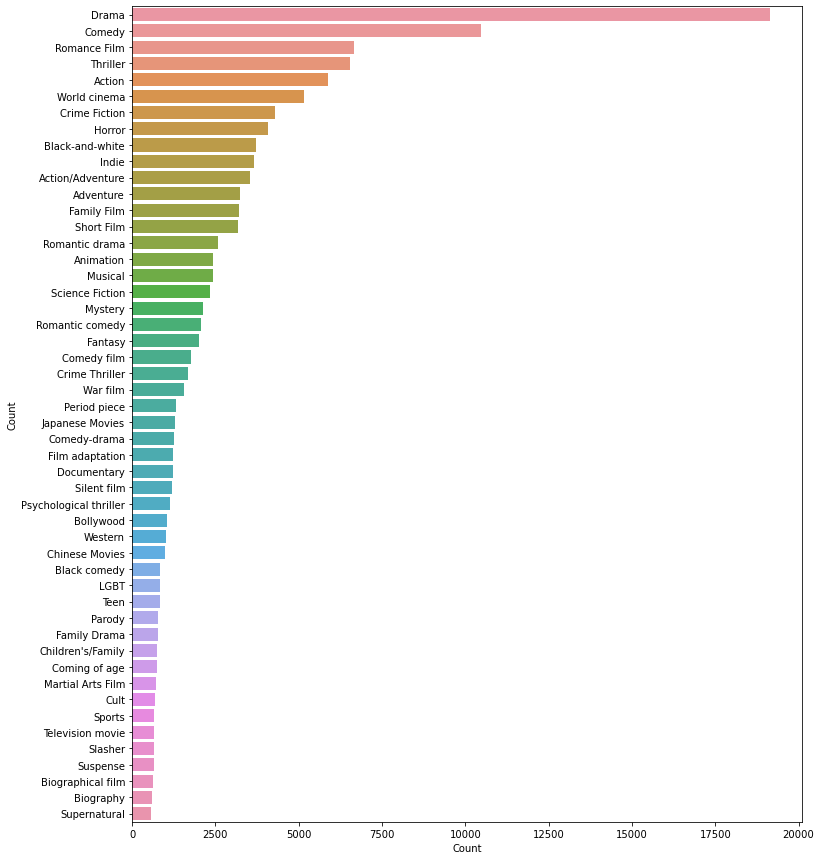

In [12]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

Next, we will clean our data a bit. I will use some very basic text cleaning steps(as that is not the focus area of this article):

In [13]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

Let’s apply the function on the movie plots by using the apply-lambda duo:

In [14]:
movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))

<ipython-input-14-cba7721b10bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))


In the clean_plot column, all the text is in lowercase and there are also no 
punctuation marks. Our text cleaning has worked like a charm.

The function below will visualize the words and their frequency in a set 
of documents. Let’s use it to find out the most frequent words in the movie
plots column:

In [15]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

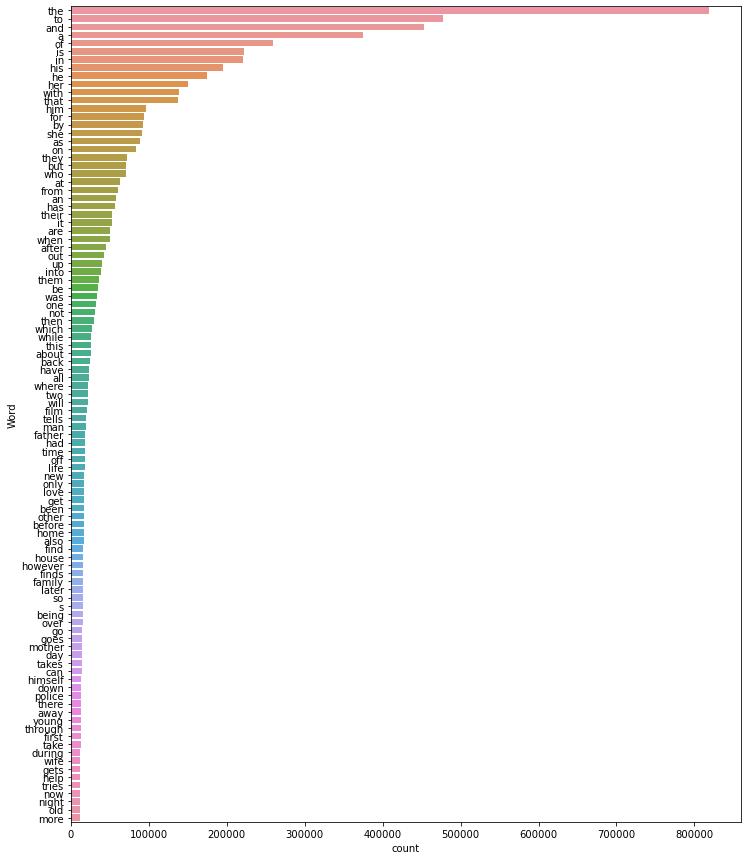

In [16]:
# print 100 most frequent words 
freq_words(movies_new['clean_plot'], 100)

Most of the terms in the above plot are stopwords. These stopwords carry far
less meaning than other keywords in the text (they just add noise to the data). I’m going to go ahead and remove them from the plots’ text. 
You can download the list of stopwords from the nltk library:

[nltk_data] Downloading package stopwords to /Users/ugur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-17-fa33059cbbd3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))


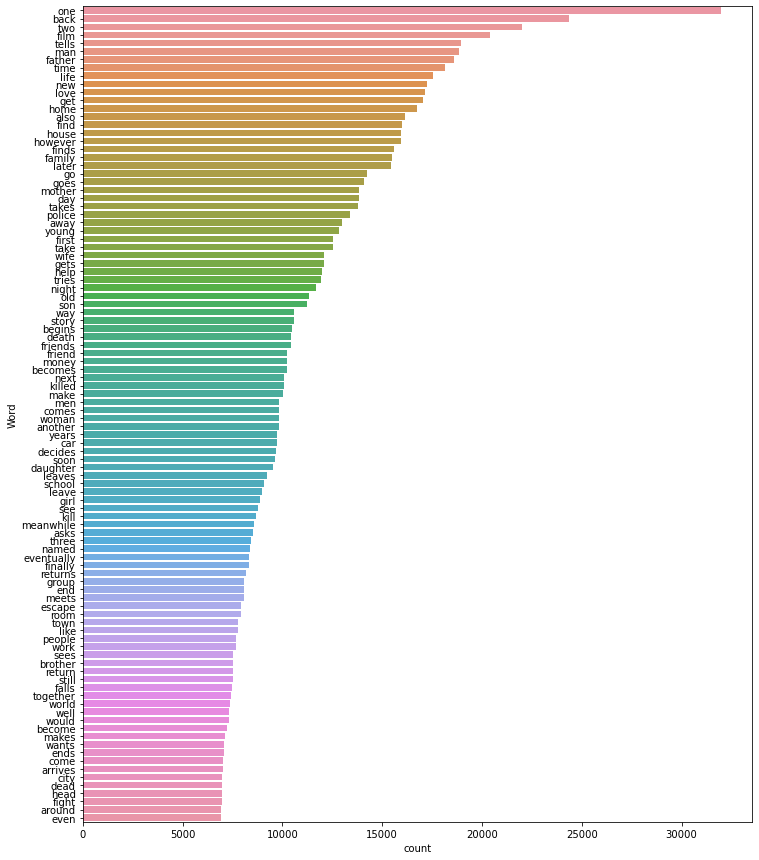

In [17]:
nltk.download('stopwords')

# Let’s remove the stopwords:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))

#Check the most frequent terms sans the stopwords:

freq_words(movies_new['clean_plot'], 100)

## Converting Text to Features

I mentioned earlier that we will treat this multi-label classification 
problem as a Binary Relevance problem. Hence, we will now one hot encode 
the target variable, i.e., genre_new by using sklearn’s 
MultiLabelBinarizer( ). Since there are 363 unique genre tags, 
there are going to be 363 new target variables.

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(movies_new['genre_new'])

Now, it’s time to turn our focus to extracting features from the cleaned 
version of the movie plots data. For this article, I will be using TF-IDF 
features. Feel free to use any other feature extraction method you are 
comfortable with, such as Bag-of-Words, word2vec, GloVe, or ELMo.

In [19]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

I have used the 10,000 most frequent words in the data as my features. 
You can try any other number as well for the max_features parameter.

Now, before creating TF-IDF features, we will split our data into train and 
validation sets for training and evaluating our model’s performance. 
I’m going with a 80-20 split – 80% of the data samples in the train set and 
the rest in the validation set:

In [20]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_plot'], y, test_size=0.2, random_state=9)

Now we can create features for the train and the validation set:

In [21]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

## Build Your Movie Genre Prediction Model 

We are all set for the model building part! This is what we’ve been waiting 
for.

Remember, we will have to build a model for every one-hot encoded target 
variable. Since we have 363 target variables, we will have to fit 
363 different models with the same set of predictors (TF-IDF features).

As you can imagine, training 363 models can take a considerable amount of 
time on a modest system. Hence, I will build a Logistic Regression model as 
it is quick to train on limited computational power:

In [22]:
from sklearn.linear_model import LogisticRegression
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier
# Performance metric
from sklearn.metrics import f1_score

We will use sk-learn’s OneVsRestClassifier class to solve this problem as a Binary Relevance or one-vs-all problem:

In [23]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

Finally, fit the model on the train set:

In [24]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

/Users/ugur/opt/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 48 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/Users/ugur/opt/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 182 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/Users/ugur/opt/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 214 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/Users/ugur/opt/anaconda3/lib/python3.8/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 245 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


OneVsRestClassifier(estimator=LogisticRegression())

Predict movie genres on the validation set:

In [25]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [26]:
#Let’s check out a sample from these predictions:
print(y_pred[3])

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


It is a binary one-dimensional array of length 363. Basically, it is the 
one-hot encoded form of the unique genre tags. We will have to find a way 
to convert it into movie genre tags.

Luckily, sk-learn comes to our rescue once again. We will use the 
inverse_transform( ) function along with the MultiLabelBinarizer( ) 
object to convert the predicted arrays into movie genre tags:

In [27]:
print(multilabel_binarizer.inverse_transform(y_pred)[3])

# evaluate performance
f1_score = f1_score(yval, y_pred, average="micro")
print(f1_score)

('Action',)
0.31546918946560987


## Create Inference Function

Wait – we are not done with the problem yet. We also have to take care of 
the new data or new movie plots that will come in the future, right? Our 
movie genre prediction system should be able to take a movie plot in raw 
form as input and generate its genre tag(s).

To achieve this, let’s build an inference function. It will take a movie 
plot text and follow the below steps:

* Remove stopwords from the cleaned text
* Extract features from the text
* Make predictions
* Return the predicted movie genre tags

In [28]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [29]:
# Let’s test this inference function on a few samples from our validation set:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", movies_new['movie_name'][k], 
        "\nPredicted genre: ", infer_tags(xval[k]))
    print("Actual genre: ",movies_new['genre_new'][k], "\n")

Movie:  Blitz 
Predicted genre:  [('Crime Fiction', 'Crime Thriller', 'Drama', 'Thriller')]
Actual genre:  ['Thriller', 'Crime Thriller'] 

Movie:  Knight and Day 
Predicted genre:  [()]
Actual genre:  ['Action/Adventure', 'Thriller', 'Action', 'Comedy', 'Adventure'] 

Movie:  The Russell Affair 
Predicted genre:  [()]
Actual genre:  ['Silent film'] 

Movie:  Downtown 81 
Predicted genre:  [('Comedy',)]
Actual genre:  ['Drama', 'Punk rock', 'Biography', 'Comedy-drama', 'Indie'] 

Movie:  The Mystery of the Double Cross 
Predicted genre:  [()]
Actual genre:  ['Silent film', 'Action', 'Black-and-white'] 

